# Settings

In [1]:
# libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datasage.styles import DARK_THEME,LIGHT_THEME,theme
from datasage.core import Leonardo
import matplotlib.colors
import matplotlib.font_manager as fm
import mplcyberpunk
leo = Leonardo()
plt.style.use(LIGHT_THEME)

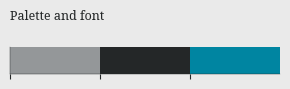

In [2]:
# settings
font_family = leo.setup_google_font()
plt.rcParams['font.family'] = font_family
# plt.rcParams['figure.dpi'] = 300

# palette
colors = ['#949799', '#242728', '#0085a1']
ccmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
sns.palplot(colors,size=1)
plt.title('Palette and font',size=9)
plt.show()

# Reading data and features engineering

[Dataset](https://www.kaggle.com/datasets/lorenzozoppelletto/financial-risk-for-loan-approval/)

In [3]:
df = pd.read_csv('loan.csv')
# renaming columns for a better understanding
df.columns = [x.lower() if '_' in x else re.sub('(?<!^)(?=[A-Z])', '_', x).lower() for x in df.columns.to_list()]
# a cleaned version
cldf = df.copy()

'''Features engineering'''
# age group bins
df['age_bins'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 65, 100],labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
# experience group bins
df['experience_bins'] = pd.cut(df['experience'], bins=[0, 5, 10, 15, 20, 25, 100],labels=['0-5', '6-10', '11-15', '16-20', '21-25', '25+'])
# job tenure bins
df['job_tenure_bins'] = pd.cut(df['job_tenure'], bins=[0, 2, 4, 6, 8, 10, 12, 14, 16],labels=['0-2', '3-4', '5-6', '7-8', '9-10', '11-12', '13-14', '15-16'])
# risk level
df['risk_level'] = pd.qcut(df['risk_score'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
# net worth level
df['net_worth_level'] = pd.qcut(df['net_worth'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
# assets and liabilities percentages
df['asset_percentage'] = df['total_assets'] / (df['total_assets'] + df['total_liabilities'])
df['liability_percentage'] = df['total_liabilities'] / (df['total_assets'] + df['total_liabilities'])
# asset coverage ratio
df['asset_coverage_ratio'] = df['total_assets'] / df['loan_amount']

# EDA

## 1. The loan approval landscape

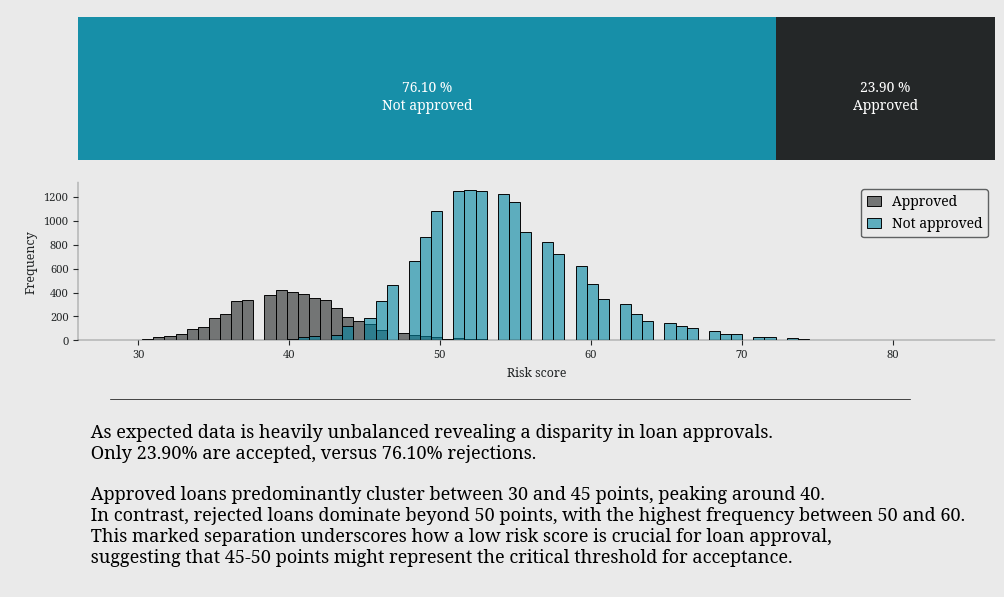

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))

# binary ratio plot
leo.binary_ratio_plot(data=df, column_name='loan_approved', target_zero_name="Not approved", target_one_name="Approved", ax=ax1)

# let's see distribution of risk score by approval status
sns.histplot(data=df, x='risk_score', hue='loan_approved', multiple="layer", alpha=0.6, ax=ax2)
ax2.set_xlabel('Risk score')
ax2.set_ylabel('Frequency')
ax2.legend(labels=['Approved', 'Not approved'],loc='upper right')

leo.insights_box(fig,
                 fontsize=13,
                 position='bottom',
                 x=0,
                 y=-0.02,
                 text=
                 """
                 As expected data is heavily unbalanced revealing a disparity in loan approvals. 
                 Only 23.90% are accepted, versus 76.10% rejections.
                 
                 Approved loans predominantly cluster between 30 and 45 points, peaking around 40.
                 In contrast, rejected loans dominate beyond 50 points, with the highest frequency between 50 and 60.
                 This marked separation underscores how a low risk score is crucial for loan approval, 
                 suggesting that 45-50 points might represent the critical threshold for acceptance.
                 """)   

plt.tight_layout()
plt.show()

## 2. Income: first line of defense

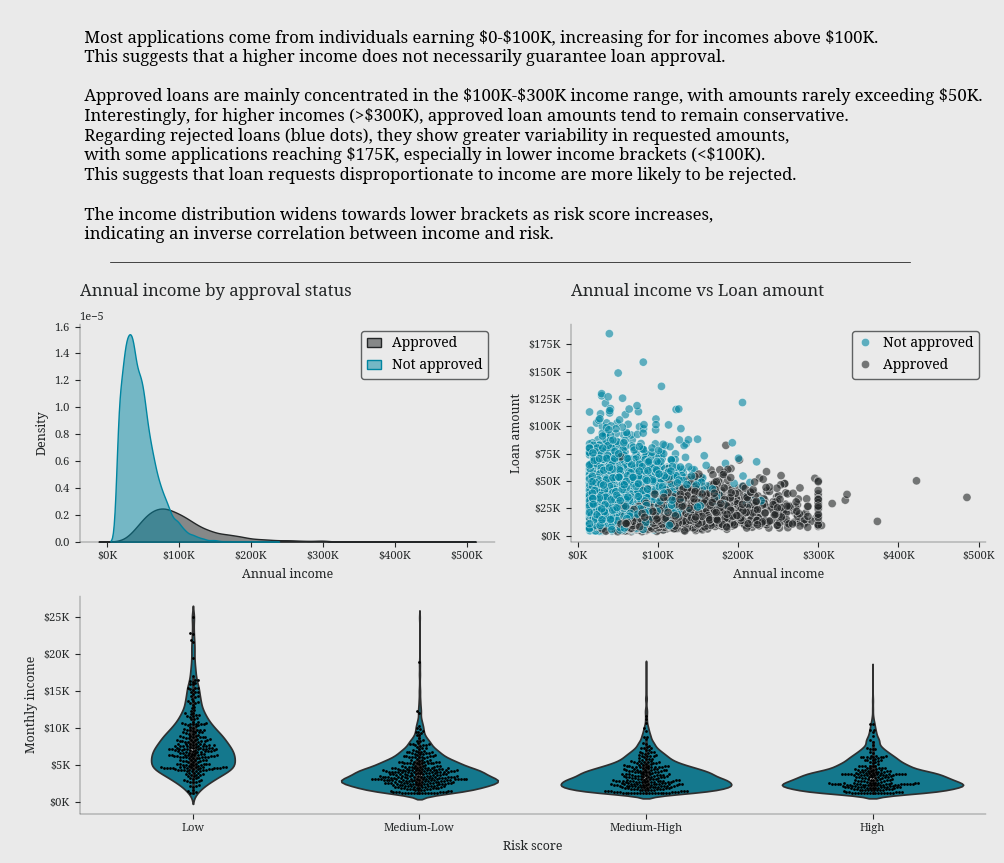

In [63]:
fig, (ax1, ax2, ax3) = leo.create_layout( [(0,0,1,1), (0,1,1,1), (1,0,1,2)], figsize=(10,6))

# let's see the annual income of who get the loan approved
sns.kdeplot(data=df, x='annual_income', hue='loan_approved', fill=True, alpha=0.5, ax=ax1, legend=False)
ax1.set_title('Annual income by approval status')
ax1.set_xlabel('Annual income')
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:,.0f}K'))
ax1.legend(labels=['Approved', 'Not approved'], loc='upper right')

# how the income affect the loan amount requested?
sns.scatterplot(data=df, x='annual_income', y='loan_amount', hue='loan_approved',sizes=(20, 200), alpha=0.6, ax=ax2)
ax2.set_title('Annual income vs Loan amount')
ax2.set_xlabel('Annual income')
ax2.set_ylabel('Loan amount')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:,.0f}K'))
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:,.0f}K'))
handles, _ = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, labels=['Not approved', 'Approved'], loc='upper right')

# how monthly income change with different risk score levels
sns.violinplot(data=df, x='risk_level', y='monthly_income', ax=ax3, legend=False)
sns.swarmplot(data=df.head(1000), x='risk_level', y='monthly_income', color='black', size=2, ax=ax3, legend=False)
ax3.set_ylabel('Monthly income')
ax3.set_xlabel('Risk score')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:,.0f}K'))

leo.insights_box(fig,
                 fontsize=12,
                 position='top',
                 x=0,
                 y=1.43,
                 text=
                 """
                 Most applications come from individuals earning $0-\$100K, increasing for for incomes above \$100K.
                 This suggests that a higher income does not necessarily guarantee loan approval.
                 
                 Approved loans are mainly concentrated in the $100K-\$300K income range, with amounts rarely exceeding \$50K. 
                 Interestingly, for higher incomes (>\$300K), approved loan amounts tend to remain conservative. 
                 Regarding rejected loans (blue dots), they show greater variability in requested amounts, 
                 with some applications reaching \$175K, especially in lower income brackets (<\$100K).
                 This suggests that loan requests disproportionate to income are more likely to be rejected.

                 The income distribution widens towards lower brackets as risk score increases, 
                 indicating an inverse correlation between income and risk.
                 """) 

plt.tight_layout()
plt.show()

## 3. Who gets loans?

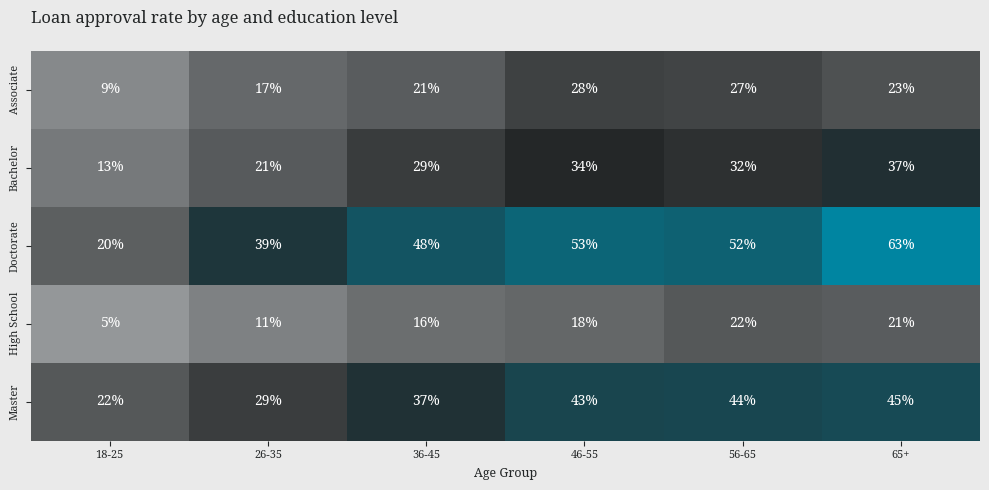

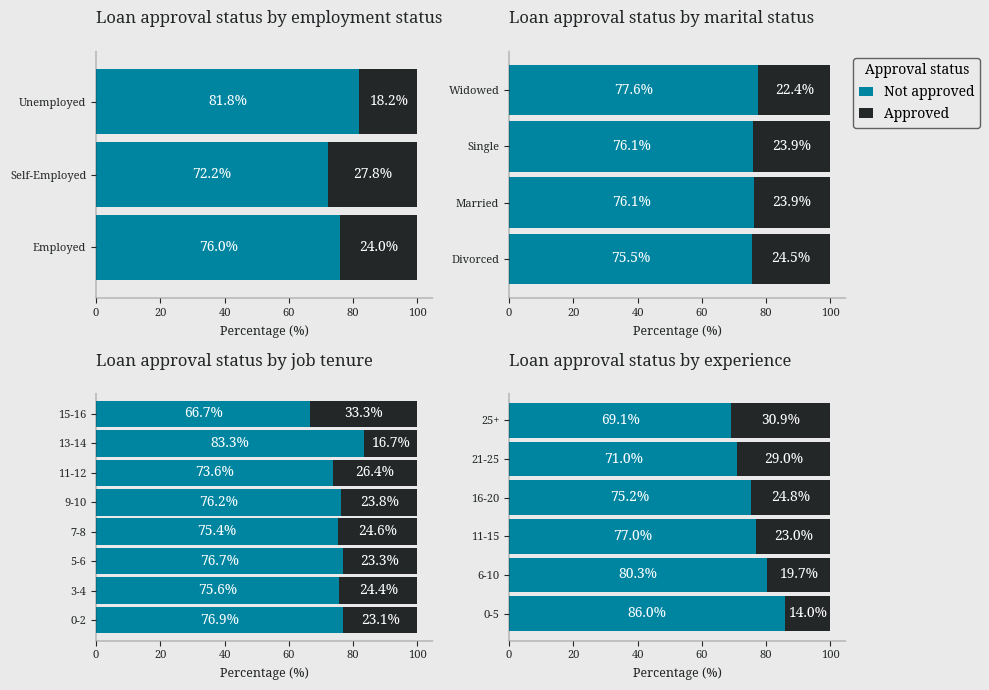

In [6]:
approval_matrix = pd.pivot_table(df, values='loan_approved',index='education_level',columns='age_bins',aggfunc='mean')

plt.figure(figsize=(10, 5))
sns.heatmap(approval_matrix, annot=True, fmt='.0%',cmap=ccmap,cbar=False)
plt.title('Loan approval rate by age and education level')
plt.xlabel('Age Group')
plt.ylabel('')
plt.tight_layout()
plt.show()

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 7))

leo.stacked_bars_plot(data=df, x='employment_status', y='loan_approved', ax=ax1)
ax1.set_title('Loan approval status by employment status')
leo.stacked_bars_plot(data=df, x='marital_status', y='loan_approved', ax=ax2)
ax2.set_title('Loan approval status by marital status')
leo.stacked_bars_plot(data=df, x='job_tenure_bins', y='loan_approved', ax=ax3)
ax3.set_title('Loan approval status by job tenure')
leo.stacked_bars_plot(data=df, x='experience_bins', y='loan_approved', ax=ax4)
ax4.set_title('Loan approval status by experience')

ax2.legend(title='Approval status', labels=['Not approved', 'Approved'], bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 4. Wealth indicators

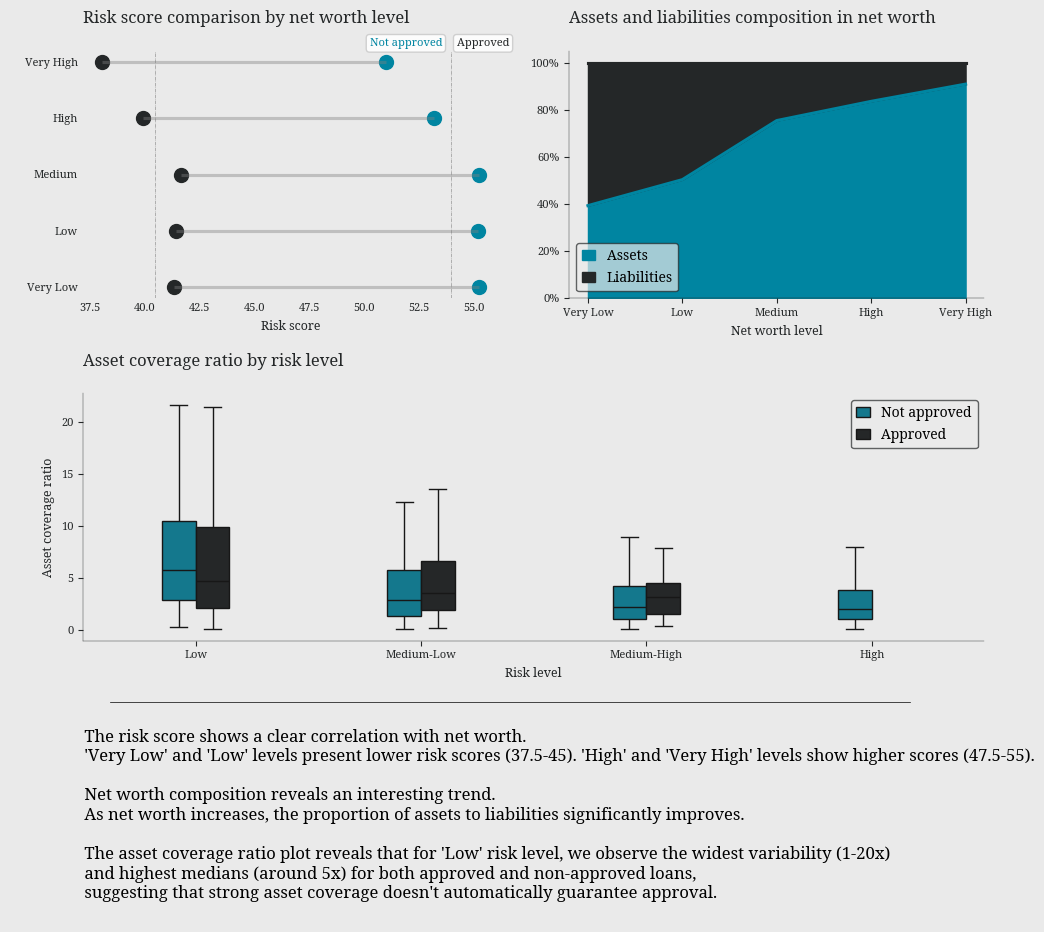

In [73]:
fig, (ax1, ax2, ax3) = leo.create_layout( [(0,0,1,1), (0,1,1,1), (1,0,1,2)], figsize=(10, 7))

# risk score and loan approval status by net worth level
leo.dumbbell_plot(df=df, group_col='loan_approved',category_col='net_worth_level',value_col='risk_score',ax=ax1,labels=['Not approved','Approved'])
ax1.set_title('Risk score comparison by net worth level')
ax1.set_xlabel('Risk score')

# total assets and liabilities proportions by net worth level
df.groupby('net_worth_level')[['asset_percentage', 'liability_percentage']].mean().rename(columns={'asset_percentage': 'Assets', 'liability_percentage': 'Liabilities'}).plot(kind='area', stacked=True, ax=ax2)
ax2.set_title('Assets and liabilities composition in net worth')
ax2.set_xlabel('Net worth level')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax2.set_xticks(range(5))
ax2.set_xticklabels(['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# the asset coverage (total assets / loan amount) ratio by risk level
ax = sns.boxplot(data=df, x='risk_level', y='asset_coverage_ratio', showfliers=False, hue='loan_approved', width=0.3, ax=ax3)
ax3.set_title('Asset coverage ratio by risk level')
ax3.set_xlabel('Risk level')
ax3.set_ylabel('Asset coverage ratio')
handles, _ = ax3.get_legend_handles_labels()
ax3.legend(handles=handles, labels=['Not approved', 'Approved'])

leo.insights_box(fig,
                 fontsize=12,
                 position='bottom',
                 x=0,
                 y=-0.02,
                 text=
                 """
                 The risk score shows a clear correlation with net worth.
                 'Very Low' and 'Low' levels present lower risk scores (37.5-45). 'High' and 'Very High' levels show higher scores (47.5-55).
                 
                 Net worth composition reveals an interesting trend.
                 As net worth increases, the proportion of assets to liabilities significantly improves.

                 The asset coverage ratio plot reveals that for 'Low' risk level, we observe the widest variability (1-20x) 
                 and highest medians (around 5x) for both approved and non-approved loans, 
                 suggesting that strong asset coverage doesn't automatically guarantee approval.
                 """) 

plt.tight_layout()
plt.show()

## 5. Credit history: the trust factor

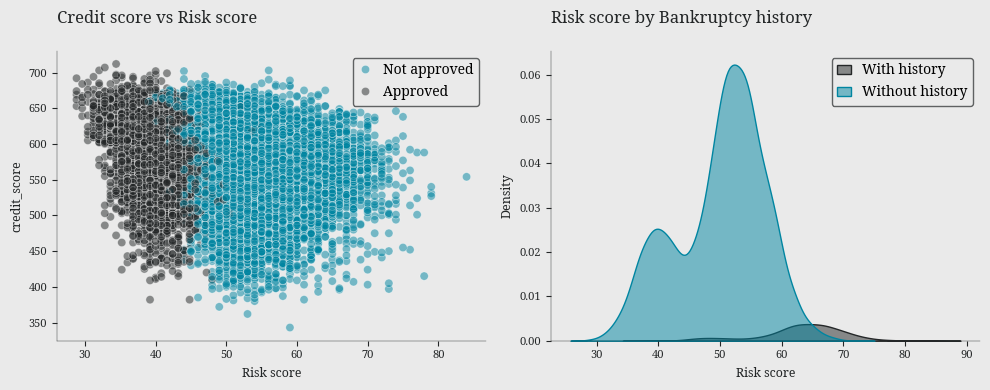

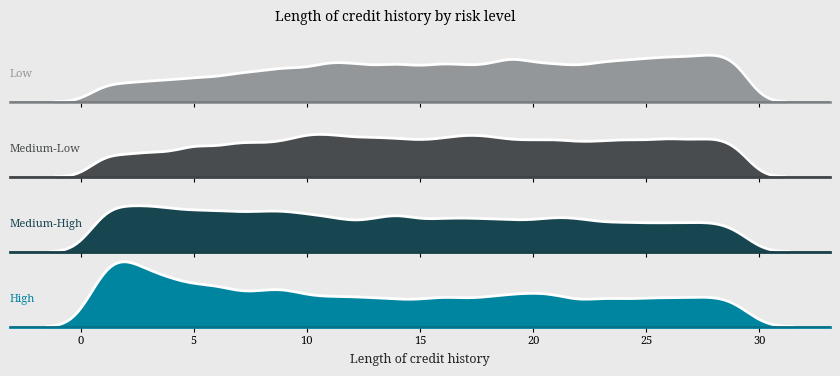

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(data=df, x='risk_score', y='credit_score',hue='loan_approved', ax=ax1, alpha=0.5)
ax1.set_title('Credit score vs Risk score')
ax1.set_xlabel('Risk score')
handles, _ = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=['Not approved', 'Approved'], loc='upper right')

sns.kdeplot(data=df, x='risk_score', hue='bankruptcy_history', fill=True, alpha=0.5, ax=ax2, legend=False)
ax2.set_title('Risk score by Bankruptcy history')
ax2.set_xlabel('Risk score')
ax2.legend(labels=['With history', 'Without history'], loc='upper right')

plt.tight_layout()
plt.show()

leo.ridge_plot(data=df,x_var='length_of_credit_history',group_var='risk_level',cmap=ccmap,height=1,aspect=9,fontsize_facets=8)
plt.xlabel('Length of credit history')
plt.suptitle('Length of credit history by risk level',y=0.90,size=10,va='baseline')
plt.show()

## 6. The approval formula

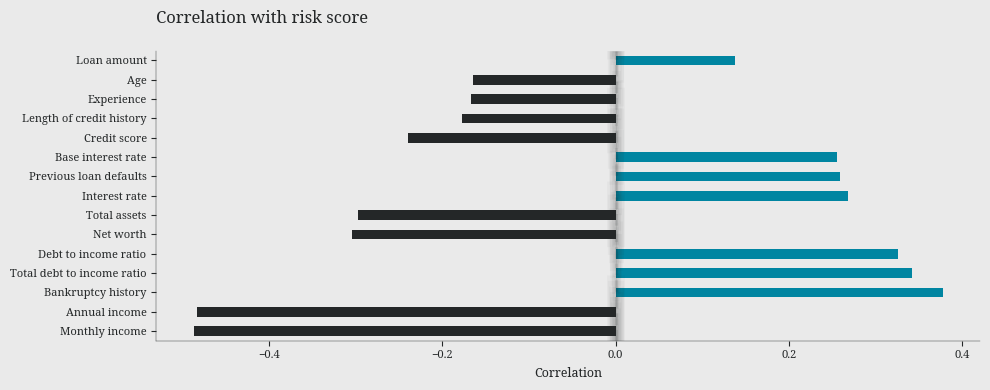

In [89]:
# Select numeric columns only
numeric_cols = cldf.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('risk_score')

# Calculate correlations with risk_score
correlations = cldf[numeric_cols + ['risk_score']].corr()['risk_score'].drop(['risk_score','loan_approved']).sort_values(key=abs, ascending=False)

# renaming index
correlations.index = [col.replace('_', ' ').capitalize() for col in correlations.index]

plt.figure(figsize=(10, 4))
bars = correlations.head(15).plot(kind='barh', color=np.where(correlations > 0, '#0085a1', '#242728'),alpha=1)
plt.axvline(x=0, color='#242728', linestyle='--', alpha=0.1)
plt.xlabel('Correlation')
plt.title('Correlation with risk score')
mplcyberpunk.add_glow_effects()
plt.tight_layout()
plt.show()